### Import Backtesting, Data Cleaning Library into Python Environment

In [1]:
import sys
sys.path.insert(0,'/Users/paulcao/trading_dashboard')

from data.data import *
from datetime import datetime, timedelta

data_dir = "/Users/paulcao/historical_data"

### Figure out Last Date

In [2]:
reset = False
source_from_backup = False

In [3]:
import pandas as pd
from os.path import exists
import io

df, max_date, next_date = None, None, None
source = AmazonS3Source()

if exists(data_dir + "/out.csv") and not source_from_backup:
    df = pd.read_csv(data_dir + "/out.csv")
    dates = df['quote_date'].unique().tolist()
    max_date = max(dates, key=lambda d: datetime.strptime(d, "%Y-%m-%d"))
    max_date = datetime.strptime(max_date, '%Y-%m-%d')
    next_date = max_date + timedelta(days=1)
    print("Sourcing locally:")
    print(next_date)
elif source_from_backup:
    res = source.get_raw_object('out.csv')
    df = pd.read_csv(io.BytesIO(res))
    
    dates = df['quote_date'].unique().tolist()
    max_date = max(dates, key=lambda d: datetime.strptime(d, "%Y-%m-%d"))
    max_date = datetime.strptime(max_date, '%Y-%m-%d')
    next_date = max_date + timedelta(days=1)
    print("Sourcing from S3:")
    print(next_date)
    
    
first_date = datetime(2022, 1, 1, 0, 0, 0, 0)

Sourcing locally:
2023-01-05 00:00:00


### Download Raw Data from Amazon Options Data Archive

In [5]:
today = datetime.now()

if not next_date or reset:
    source.get_object(first_date, today, data_dir)
else:
    source.get_object(next_date, today, data_dir)

### Clean out Bad Data Rows, Calculate Greeks and Aggregate to 1 CSV File

In [6]:
from data.data import *

if not reset:
    source = CBOESource(data_dir, put=False, min_date=max_date)
    source.write(data_dir + "/out2.csv")

    if exists(data_dir + "/out2.csv"):
        df2 = pd.read_csv(data_dir + "/out2.csv")
        res = pd.concat([df, df2])
        res.to_csv(data_dir + "/out.csv", index=False)
        print("out.csv updated")
else:
    source = CBOESource(data_dir, put=False)
    source.write(data_dir + "/out.csv")

out.csv updated


In [7]:
df = pd.read_csv(data_dir + "/out.csv")

In [8]:
df["quote_datetime"].unique()

array(['2022-01-03 15:00:00', '2022-01-04 15:00:00',
       '2022-01-05 15:00:00', '2022-01-06 15:00:00',
       '2022-01-07 15:00:00', '2022-01-10 15:00:00',
       '2022-01-11 15:00:00', '2022-01-12 15:00:00',
       '2022-01-13 15:00:00', '2022-01-14 15:00:00',
       '2022-01-18 15:00:00', '2022-01-19 15:00:00',
       '2022-01-20 15:00:00', '2022-01-21 15:00:00',
       '2022-01-24 15:00:00', '2022-01-25 15:00:00',
       '2022-01-26 15:00:00', '2022-01-27 15:00:00',
       '2022-01-28 15:00:00', '2022-01-31 15:00:00',
       '2022-02-01 15:00:00', '2022-02-02 15:00:00',
       '2022-02-03 15:00:00', '2022-02-04 15:00:00',
       '2022-02-07 15:00:00', '2022-02-08 15:00:00',
       '2022-02-09 15:00:00', '2022-02-10 15:00:00',
       '2022-02-11 15:00:00', '2022-02-14 15:00:00',
       '2022-02-15 15:00:00', '2022-02-16 15:00:00',
       '2022-02-17 15:00:00', '2022-02-18 15:00:00',
       '2022-02-22 15:00:00', '2022-02-23 15:00:00',
       '2022-02-24 15:00:00', '2022-02-25 15:0

### Define BWB-RD and PBR hedge strategy

In [9]:
from backtest_feed.pandas_bar_feed import PandasBarFeed
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.stratanalyzer import drawdown
from pyalgotrade import plotter

from pyalgotrade import strategy
import datetime
import math

import numpy as np


class BWB(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, useAdjustedClose=True, traunches=3, cash=100000, dte=100):
        strategy.BacktestingStrategy.__init__(self, feed, cash)
        self.setUseAdjustedValues(useAdjustedClose)
        self.getBroker().setAllowNegativeCash(True)
        self.__instrument = instrument
        self.chain = None
        self.delta_chain = None
        self.liquidated = False
        self.expiration_date = None
        self.option = None
        self.traunches = traunches
        self.dte = dte
        self.cash = cash

    def get_closet_expiration(self, n_days, chain):
        current_datetime = (self.getCurrentDateTime()).date()
        expiration_datetime = current_datetime + datetime.timedelta(days=n_days)
        option_chain = chain
        option_chain = list(filter(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date() \
                                             > expiration_datetime, option_chain))
        expiration_dates = list(map(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date(), option_chain))
        return min(expiration_dates)

    def get_previous_expiration(self, chain, expiry):
        option_chain = filter(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date() \
                                             < expiry, chain)
        expiration_dates = list(map(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date(), option_chain))
        return max(expiration_dates)

    def get_chain(self, bars):
        return bars.keys()

    def enterPosition(self, bars):
        close = bars[bars.keys()[0]].getUnderlyingPrice()
        original_option_chain = self.get_chain(bars)
        expiration_date = self.get_closet_expiration(self.dte, original_option_chain)
        self.expiration_date = expiration_date

        option_chain = filter(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date() \
                                             == expiration_date, original_option_chain)
        put_option_chain = list(filter(lambda option: option[-9] == 'P', option_chain))

        put_option_chain_30 = original_option_chain
        expiration_date_30 = self.get_closet_expiration(self.dte-33, put_option_chain_30)
        option_chain_30 = filter(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date() \
                                                == expiration_date_30, put_option_chain_30)
        put_option_chain_30 = list(filter(lambda option: option[-9] == 'P', option_chain_30))
        
        call_option_chain_plus30 = original_option_chain
        expiration_date_plus30 = self.get_closet_expiration(self.dte+33, call_option_chain_plus30)
        call_option_chain_plus30 = filter(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date() \
                                                == expiration_date_plus30, call_option_chain_plus30)
        call_option_chain_plus30 = list(filter(lambda option: option[-9] == 'C', call_option_chain_plus30))
        
        call_option_chain = original_option_chain
        expiration_date = self.get_closet_expiration(self.dte, original_option_chain)
        call_option_chain = filter(lambda option: datetime.datetime.strptime(option[-15:-9], '%y%m%d').date() \
                                                == expiration_date, call_option_chain)
        call_option_chain = list(filter(lambda option: option[-9] == 'C', call_option_chain))

        self.short = min(put_option_chain, key=lambda option: math.fabs(12.5 + (float(bars[option].getDelta()))))
        self.upper_leg = min(put_option_chain, key=lambda option: math.fabs(20 + (float(bars[option].getDelta()))))
        self.rd_lower_leg = min(put_option_chain, key=lambda option: math.fabs(5 + (float(bars[option].getDelta()))))
        
        #self.call_front_leg = min(call_option_chain, key=lambda option: math.fabs(30 - (float(bars[option].getDelta()))))
        #self.call_back_leg = min(call_option_chain_plus30, key=lambda option: math.fabs(30 - (float(bars[option].getDelta()))))
        
        self.call_front_leg = min(call_option_chain, key=lambda option: math.fabs(30 - float(bars[option].getDelta())) \
                                  if not np.isnan(float(bars[option].getDelta())) else 30)
        self.call_back_leg = min(call_option_chain_plus30, key=lambda option: math.fabs(30 - float(bars[option].getDelta())) \
                                 if not np.isnan(float(bars[option].getDelta())) else 30)
        
        self.info("Enter " + str(-self.traunches * 10) + " " + str(self.short))
        self.info("Enter " + str(self.traunches * 5) + " " + str(self.upper_leg))
        self.info("Enter " + str(self.traunches * 5) + " " + str(self.rd_lower_leg))
        
        self.info("Enter " + str(-self.traunches * 5) + " " + str(self.call_front_leg))
        self.info("Enter " + str(self.traunches * 5) + " " + str(self.call_back_leg))

        self.bwb_price = -float(bars[self.short].getClose()) * 2 + float(bars[self.rd_lower_leg].getClose()) \
                    + float(bars[self.upper_leg].getClose()) - float(bars[self.call_front_leg].getClose()) \
                    + float(bars[self.call_back_leg].getClose())

        self.info("SPX at " + str(close))
        self.info("Entered BWB-CD price at: " + str(self.bwb_price))

        self.marketOrder(self.short, -self.traunches * 10, goodTillCanceled=True)
        self.marketOrder(self.rd_lower_leg, self.traunches * 5, goodTillCanceled=True)
        self.marketOrder(self.upper_leg, self.traunches * 5, goodTillCanceled=True)
        
        self.marketOrder(self.call_front_leg, -self.traunches * 5, goodTillCanceled=True)
        self.marketOrder(self.call_back_leg, self.traunches * 5, goodTillCanceled=True)

    def onBars(self, bars):

        if self.liquidated == False:
            current_datetime = self.getCurrentDateTime().date()

            if self.expiration_date != None:
                bwb_market_price = -float(bars[self.short].getClose()) * 2 + float(bars[self.rd_lower_leg].getClose()) \
                                   + float(bars[self.upper_leg].getClose()) - float(bars[self.call_front_leg].getClose()) \
                                   + float(bars[self.call_back_leg].getClose())
                
                pnl_per_traunch = (bwb_market_price - self.bwb_price) * 500
                self.info("PnL per Traunch: " + str(pnl_per_traunch))

            if (self.expiration_date != None) and ( \
                            (self.expiration_date - current_datetime) < datetime.timedelta(
                        days=60) or pnl_per_traunch >= 700 or pnl_per_traunch <= -1400):

                self.marketOrder(self.short, self.traunches * 10, goodTillCanceled=True)
                self.marketOrder(self.upper_leg, -self.traunches * 5, goodTillCanceled=True)
                self.marketOrder(self.rd_lower_leg, -self.traunches * 5, goodTillCanceled=True)
                
                self.marketOrder(self.call_front_leg, self.traunches * 5, goodTillCanceled=True)
                self.marketOrder(self.call_back_leg, -self.traunches * 5, goodTillCanceled=True)
                
                self.info("Liquidate BWB price at: " + str(bwb_market_price))

                self.info("Liquidate BWB:" + str(current_datetime))
                self.liquidated = True

        if self.liquidated == True or self.expiration_date == None:
            self.enterPosition(bars)
            self.liquidated = False

### Run backtest on the defined strategy (Enter 100-120DTE, 0.365-0.32-0.25 Delta, Exit 70DTE)

2022-01-03 15:00:00 strategy [INFO] Enter -2500 SPXW220414P04125000
2022-01-03 15:00:00 strategy [INFO] Enter 1250 SPXW220414P04365000
2022-01-03 15:00:00 strategy [INFO] Enter 1250 SPX220414P03640000
2022-01-03 15:00:00 strategy [INFO] Enter -1250 SPXW220414C04985000
2022-01-03 15:00:00 strategy [INFO] Enter 1250 SPX220520C05030000
2022-01-03 15:00:00 strategy [INFO] SPX at 4787.55005
2022-01-03 15:00:00 strategy [INFO] Entered BWB-CD price at: 12.649999999999999
2022-01-03 15:00:00 strategy [INFO] PnL per Traunch: 325.00000000000637
2022-01-04 15:00:00 strategy [INFO] PnL per Traunch: -349.99999999999784
2022-01-05 15:00:00 strategy [INFO] PnL per Traunch: -549.9999999999936
2022-01-06 15:00:00 strategy [INFO] PnL per Traunch: -424.99999999999005
2022-01-07 15:00:00 strategy [INFO] PnL per Traunch: -799.9999999999936
2022-01-10 15:00:00 strategy [INFO] PnL per Traunch: 175.00000000000426
2022-01-11 15:00:00 strategy [INFO] PnL per Traunch: 600.0000000000032
2022-01-12 15:00:00 strate

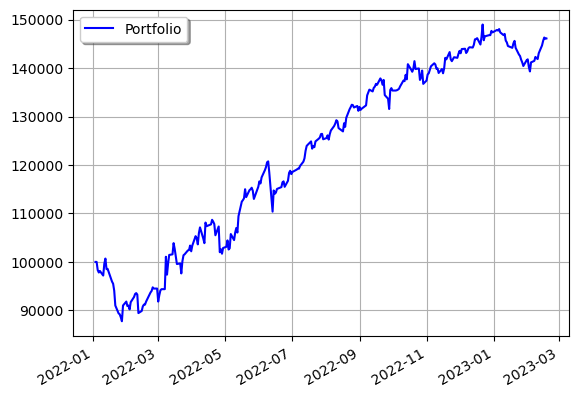

In [10]:
#true tranches = 2.5; 2.5 x 100 options multiplier
myStrategy = BWB(PandasBarFeed.load_feed(data_dir + "/out.csv"), "SPX", useAdjustedClose=True, traunches=250)

returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)

# Attach the plotter to the strategy.
plt = plotter.StrategyPlotter(myStrategy, plotAllInstruments=False, plotBuySell=False)

returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)
drawDownAnalyzer = drawdown.DrawDown()
myStrategy.attachAnalyzer(drawDownAnalyzer)

myStrategy.run()
plt.plot()

In [11]:
cumRet = returnsAnalyzer.getCumulativeReturns()[-1] * 100
print("Cumulative returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))
print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

Cumulative returns: 46.12 %
Max. drawdown: 12.85 %
Longest drawdown duration: 58 days 00:00:00


### Positions & Orders

In [17]:
myStrategy.getBroker().getPositions()

{'SPXW230421P03310000': -2500,
 'SPX230421P02975000': 1250,
 'SPXW230421P03490000': 1250,
 'SPX230421C04160000': -1250,
 'SPXW230519C04210000': 1250}

In [18]:
myStrategy.getBroker().getActiveOrders()

[]